In [25]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='PROJECTID', project_access_token='PROJECT ACCESS')
pc = project.project_context

![image](https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/notebooks/headers/AutoAI-Banner_Pipeline-Notebook.png)
# Pipeline 12 Notebook - AutoAI Notebook v1.15.8

Consider these tips for working with an auto-generated notebook:
- Notebook code generated using AutoAI will execute successfully. If you modify the notebook, we cannot guarantee it will run successfully.
- This pipeline is optimized for the original data set. The pipeline might fail or produce sub-optimum results if used with different data.  If you want to use a different data set, consider retraining the AutoAI experiment to generate a new pipeline. For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>. 
- Before modifying the pipeline or trying to re-fit the pipeline, consider that the code converts dataframes to numpy arrays before fitting the pipeline (a current restriction of the preprocessor pipeline).


<a id="content"></a>
## Notebook content

This notebook contains a Scikit-learn representation of AutoAI pipeline. This notebook introduces commands for getting data, training the model, and testing the model. 

Some familiarity with Python is helpful. This notebook uses Python 3.8 and scikit-learn 0.23.2.

## Notebook goals

-  Scikit-learn pipeline definition
-  Pipeline training 
-  Pipeline evaluation

## Contents

This notebook contains the following parts:

**[Setup](#setup)**<br>
&nbsp;&nbsp;[Package installation](#install)<br>
&nbsp;&nbsp;[AutoAI experiment metadata](#variables_definition)<br>
&nbsp;&nbsp;[Watson Machine Learning connection](#connection)<br>
**[Pipeline inspection](#inspection)** <br>
&nbsp;&nbsp;[Read training data](#read)<br>
&nbsp;&nbsp;[Train and test data split](#split)<br>
&nbsp;&nbsp;[Make pipeline](#preview_model_to_python_code)<br>
&nbsp;&nbsp;[Train pipeline model](#train)<br>
&nbsp;&nbsp;[Test pipeline model](#test_model)<br>
**[Next steps](#next_steps)**<br>
**[Copyrights](#copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - scikit-learn.


In [26]:
!pip install ibm-watson-machine-learning | tail -n 1
!pip install -U autoai-libs==1.12.15 | tail -n 1
!pip install -U scikit-learn==0.23.2 | tail -n 1

<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [27]:
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import ContainerLocation

training_data_reference = [
    DataConnection(
        data_asset_id='8bcc2897-2e30-4f91-a5b9-321a459ffda7'
    ),
]
print("Got Training Data")
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/b87ef1e9-5770-49e1-84fc-76005df594ac/wml_data/2f26108a-78c5-4a24-a0cc-12ffd9432d08/data/automl',
        model_location='auto_ml/b87ef1e9-5770-49e1-84fc-76005df594ac/wml_data/2f26108a-78c5-4a24-a0cc-12ffd9432d08/data/automl/model.zip',
        training_status='auto_ml/b87ef1e9-5770-49e1-84fc-76005df594ac/wml_data/2f26108a-78c5-4a24-a0cc-12ffd9432d08/training-status.json'
    )
)
print("Got Training Result")

2021-11-26 23:37:28,952 - __PROJECT_LIB__ - ERROR - GET project failed, status 401 from https://api.dataplatform.cloud.ibm.com/v2/projects/3f9fbf88-d659-4ba7-8232-c05450a5067c
{"code":401,"error":"Unauthorized","reason":"Bearer token is either missing or invalid: undefined.","message":"Access denied"}


Got Training Data
Got Training Result


Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [28]:
experiment_metadata = dict(
    prediction_type='multiclass',
    prediction_column='label',
    holdout_size=0.1,
    scoring='accuracy',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=3,
    training_data_reference=training_data_reference,
    training_result_reference=training_result_reference,
    include_only_estimators=['RandomForestClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'XGBClassifier', 'LGBMClassifier', 'SnapDecisionTreeClassifier', 'SnapRandomForestClassifier', 'SnapLogisticRegression', 'SnapSVMClassifier', 'GradientBoostingClassifier', 'ExtraTreesClassifier'],
    deployment_url='https://us-south.ml.cloud.ibm.com',
    project_id='3f9fbf88-d659-4ba7-8232-c05450a5067c',
    drop_duplicates=True
)

<a id="connection"></a>
## Watson Machine Learning connection

This cell defines the credentials required to work with the Watson Machine Learning service.

**Action:** Please provide IBM Cloud apikey following [docs](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [29]:
api_key = 'API KEY'

In [30]:
wml_credentials = {
    "apikey": api_key,
    "url": experiment_metadata['deployment_url']
}

In [31]:
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(wml_credentials)

if 'space_id' in experiment_metadata:
    wml_client.set.default_space(experiment_metadata['space_id'])
else:
    wml_client.set.default_project(experiment_metadata['project_id'])
    
training_data_reference[0]._wml_client = wml_client

<a id="inspection"></a>
# Pipeline inspection

<a id="read"></a>
## Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

**Note**: If reading data results in an error, provide data as Pandas DataFrame object, for example, reading .CSV file with `pandas.read_csv()`

In [32]:
train_X, test_X, train_y, test_y = training_data_reference[0].read(experiment_metadata=experiment_metadata, with_holdout_split=True)

<a id="preview_model_to_python_code"></a>
## Make pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

#### Import statements.

In [33]:
from autoai_libs.transformers.exportable import ColumnSelector
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TA2
import autoai_libs.utils.fc_methods
from autoai_libs.cognito.transforms.transform_utils import FS1
from sklearn.ensemble import GradientBoostingClassifier

#### Pre-processing & Estimator.

In [34]:
column_selector_0 = ColumnSelector(
    columns_indices_list=[
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
        183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226,
        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
        241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
        283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
        297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
        311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
        325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
        354, 355, 356, 357, 358, 359, 360, 361, 362, 365, 366, 367, 368, 369,
        370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
        384, 385, 386, 387, 388, 389, 390, 394, 395, 396, 397, 398, 399, 400,
        401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
        432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
        446, 447, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
        491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 505,
        506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
        520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 533, 534, 535,
        536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549,
        550, 551, 552, 553, 554, 555, 556, 557, 558, 561, 562, 563, 564, 565,
        566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579,
        580, 581, 582, 583, 584, 585, 586, 590, 591, 592, 593, 594, 595, 596,
        597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610,
        611, 612, 613, 614, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627,
        628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641,
        642, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657,
        658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 675,
        676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689,
        690, 691, 692, 693, 694, 695, 696, 697, 703, 704, 705, 706, 707, 708,
        709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722,
        723, 724, 725, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742,
        743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 762, 763, 764, 765,
        766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777,
    ]
)
numpy_column_selector_0 = NumpyColumnSelector(columns=[454])
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=["float_int_num"],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[[]],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=100001
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=100001,
    filling_values_list=[100001],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=100001,
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
pipeline_0 = make_pipeline(
    column_selector_0,
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
column_selector_1 = ColumnSelector(
    columns_indices_list=[
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
        183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226,
        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
        241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
        283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
        297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
        311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
        325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
        354, 355, 356, 357, 358, 359, 360, 361, 362, 365, 366, 367, 368, 369,
        370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
        384, 385, 386, 387, 388, 389, 390, 394, 395, 396, 397, 398, 399, 400,
        401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
        432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
        446, 447, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
        491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 505,
        506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519,
        520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 533, 534, 535,
        536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549,
        550, 551, 552, 553, 554, 555, 556, 557, 558, 561, 562, 563, 564, 565,
        566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579,
        580, 581, 582, 583, 584, 585, 586, 590, 591, 592, 593, 594, 595, 596,
        597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610,
        611, 612, 613, 614, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627,
        628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641,
        642, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657,
        658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 675,
        676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689,
        690, 691, 692, 693, 694, 695, 696, 697, 703, 704, 705, 706, 707, 708,
        709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722,
        723, 724, 725, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742,
        743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 762, 763, 764, 765,
        766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777,
    ]
)
numpy_column_selector_1 = NumpyColumnSelector(
    columns=[
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
        202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
        216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
        230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
        258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
        286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
        300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
        328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
        342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
        356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
        370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
        384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
        398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
        412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
        426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
        440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453,
        455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
        469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482,
        483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496,
        497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510,
        511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524,
        525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
        539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552,
        553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566,
        567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580,
        581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
        595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608,
        609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622,
        623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636,
        637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650,
        651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
    ]
)
float_str2_float = FloatStr2Float(
    dtypes_list=[
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num",
    ],
    missing_values_reference_list=[],
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(strategy="median", missing_values=float("nan"))
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    column_selector_1,
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        454, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
        201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
        215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
        229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
        243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
        257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
        271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
        299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
        313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
        341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
        355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
        369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
        383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396,
        397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
        411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
        425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
        439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
        453, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
        468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
        482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495,
        496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509,
        510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523,
        524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
        538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
        552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565,
        566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579,
        580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
        594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607,
        608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621,
        622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635,
        636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649,
        650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663,
        664,
    ],
)
ta2_0 = TA2(
    fun=np.add,
    name="sum",
    datatypes1=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical],
    datatypes2=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44",
        "45", "46", "47", "48", "49", "62", "63", "64", "65", "66", "67",
        "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78",
        "79", "80", "81", "89", "90", "91", "92", "93", "94", "95", "96",
        "97", "98", "99", "100", "101", "102", "103", "104", "105", "106",
        "107", "108", "109", "110", "116", "117", "118", "119", "120", "121",
        "122", "123", "124", "125", "126", "127", "128", "129", "130", "131",
        "132", "133", "134", "135", "136", "137", "138", "139", "142", "143",
        "144", "145", "146", "147", "148", "149", "150", "151", "152", "153",
        "154", "155", "156", "157", "158", "159", "160", "161", "162", "163",
        "164", "165", "166", "167", "171", "172", "173", "174", "175", "176",
        "177", "178", "179", "180", "181", "182", "183", "184", "185", "186",
        "187", "188", "189", "190", "191", "192", "193", "194", "195", "196",
        "198", "199", "200", "201", "202", "203", "204", "205", "206", "207",
        "208", "209", "210", "211", "212", "213", "214", "215", "216", "217",
        "218", "219", "220", "221", "222", "223", "224", "226", "227", "228",
        "229", "230", "231", "232", "233", "234", "235", "236", "237", "238",
        "239", "240", "241", "242", "243", "244", "245", "246", "247", "248",
        "249", "250", "251", "252", "253", "254", "255", "256", "257", "258",
        "259", "260", "261", "262", "263", "264", "265", "266", "267", "268",
        "269", "270", "271", "272", "273", "274", "275", "276", "277", "278",
        "279", "280", "281", "282", "283", "284", "285", "286", "287", "288",
        "289", "290", "291", "292", "293", "294", "295", "296", "297", "298",
        "299", "300", "301", "302", "303", "304", "305", "306", "307", "308",
        "309", "310", "311", "312", "313", "314", "315", "316", "317", "318",
        "319", "320", "321", "322", "323", "324", "325", "326", "327", "328",
        "329", "330", "331", "332", "333", "334", "335", "336", "338", "339",
        "340", "341", "342", "343", "344", "345", "346", "347", "348", "349",
        "350", "351", "352", "353", "354", "355", "356", "357", "358", "359",
        "360", "361", "362", "363", "366", "367", "368", "369", "370", "371",
        "372", "373", "374", "375", "376", "377", "378", "379", "380", "381",
        "382", "383", "384", "385", "386", "387", "388", "389", "390", "391",
        "395", "396", "397", "398", "399", "400", "401", "402", "403", "404",
        "405", "406", "407", "408", "409", "410", "411", "412", "413", "414",
        "415", "416", "417", "418", "419", "423", "424", "425", "426", "427",
        "428", "429", "430", "431", "432", "433", "434", "435", "436", "437",
        "438", "439", "440", "441", "442", "443", "444", "445", "446", "447",
        "448", "450", "451", "452", "453", "454", "455", "456", "457", "458",
        "459", "460", "461", "462", "463", "464", "465", "466", "467", "468",
        "469", "470", "471", "472", "473", "474", "475", "476", "479", "480",
        "481", "482", "483", "484", "485", "486", "487", "488", "489", "490",
        "491", "492", "493", "494", "495", "496", "497", "498", "499", "500",
        "501", "502", "503", "504", "506", "507", "508", "509", "510", "511",
        "512", "513", "514", "515", "516", "517", "518", "519", "520", "521",
        "522", "523", "524", "525", "526", "527", "528", "529", "530", "531",
        "534", "535", "536", "537", "538", "539", "540", "541", "542", "543",
        "544", "545", "546", "547", "548", "549", "550", "551", "552", "553",
        "554", "555", "556", "557", "558", "559", "562", "563", "564", "565",
        "566", "567", "568", "569", "570", "571", "572", "573", "574", "575",
        "576", "577", "578", "579", "580", "581", "582", "583", "584", "585",
        "586", "587", "591", "592", "593", "594", "595", "596", "597", "598",
        "599", "600", "601", "602", "603", "604", "605", "606", "607", "608",
        "609", "610", "611", "612", "613", "614", "615", "619", "620", "621",
        "622", "623", "624", "625", "626", "627", "628", "629", "630", "631",
        "632", "633", "634", "635", "636", "637", "638", "639", "640", "641",
        "642", "643", "646", "647", "648", "649", "650", "651", "652", "653",
        "654", "655", "656", "657", "658", "659", "660", "661", "662", "663",
        "664", "665", "666", "667", "668", "669", "670", "671", "676", "677",
        "678", "679", "680", "681", "682", "683", "684", "685", "686", "687",
        "688", "689", "690", "691", "692", "693", "694", "695", "696", "697",
        "698", "704", "705", "706", "707", "708", "709", "710", "711", "712",
        "713", "714", "715", "716", "717", "718", "719", "720", "721", "722",
        "723", "724", "725", "726", "733", "734", "735", "736", "737", "738",
        "739", "740", "741", "742", "743", "744", "745", "746", "747", "748",
        "749", "750", "751", "752", "753", "763", "764", "765", "766", "767",
        "768", "769", "770", "771", "772", "773", "774", "775", "776", "777",
        "778",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)
fs1_0 = FS1(
    cols_ids_must_keep=range(0, 665),
    additional_col_count_to_keep=36,
    ptype="classification",
)
ta2_1 = TA2(
    fun=np.multiply,
    name="product",
    datatypes1=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical],
    datatypes2=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44",
        "45", "46", "47", "48", "49", "62", "63", "64", "65", "66", "67",
        "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78",
        "79", "80", "81", "89", "90", "91", "92", "93", "94", "95", "96",
        "97", "98", "99", "100", "101", "102", "103", "104", "105", "106",
        "107", "108", "109", "110", "116", "117", "118", "119", "120", "121",
        "122", "123", "124", "125", "126", "127", "128", "129", "130", "131",
        "132", "133", "134", "135", "136", "137", "138", "139", "142", "143",
        "144", "145", "146", "147", "148", "149", "150", "151", "152", "153",
        "154", "155", "156", "157", "158", "159", "160", "161", "162", "163",
        "164", "165", "166", "167", "171", "172", "173", "174", "175", "176",
        "177", "178", "179", "180", "181", "182", "183", "184", "185", "186",
        "187", "188", "189", "190", "191", "192", "193", "194", "195", "196",
        "198", "199", "200", "201", "202", "203", "204", "205", "206", "207",
        "208", "209", "210", "211", "212", "213", "214", "215", "216", "217",
        "218", "219", "220", "221", "222", "223", "224", "226", "227", "228",
        "229", "230", "231", "232", "233", "234", "235", "236", "237", "238",
        "239", "240", "241", "242", "243", "244", "245", "246", "247", "248",
        "249", "250", "251", "252", "253", "254", "255", "256", "257", "258",
        "259", "260", "261", "262", "263", "264", "265", "266", "267", "268",
        "269", "270", "271", "272", "273", "274", "275", "276", "277", "278",
        "279", "280", "281", "282", "283", "284", "285", "286", "287", "288",
        "289", "290", "291", "292", "293", "294", "295", "296", "297", "298",
        "299", "300", "301", "302", "303", "304", "305", "306", "307", "308",
        "309", "310", "311", "312", "313", "314", "315", "316", "317", "318",
        "319", "320", "321", "322", "323", "324", "325", "326", "327", "328",
        "329", "330", "331", "332", "333", "334", "335", "336", "338", "339",
        "340", "341", "342", "343", "344", "345", "346", "347", "348", "349",
        "350", "351", "352", "353", "354", "355", "356", "357", "358", "359",
        "360", "361", "362", "363", "366", "367", "368", "369", "370", "371",
        "372", "373", "374", "375", "376", "377", "378", "379", "380", "381",
        "382", "383", "384", "385", "386", "387", "388", "389", "390", "391",
        "395", "396", "397", "398", "399", "400", "401", "402", "403", "404",
        "405", "406", "407", "408", "409", "410", "411", "412", "413", "414",
        "415", "416", "417", "418", "419", "423", "424", "425", "426", "427",
        "428", "429", "430", "431", "432", "433", "434", "435", "436", "437",
        "438", "439", "440", "441", "442", "443", "444", "445", "446", "447",
        "448", "450", "451", "452", "453", "454", "455", "456", "457", "458",
        "459", "460", "461", "462", "463", "464", "465", "466", "467", "468",
        "469", "470", "471", "472", "473", "474", "475", "476", "479", "480",
        "481", "482", "483", "484", "485", "486", "487", "488", "489", "490",
        "491", "492", "493", "494", "495", "496", "497", "498", "499", "500",
        "501", "502", "503", "504", "506", "507", "508", "509", "510", "511",
        "512", "513", "514", "515", "516", "517", "518", "519", "520", "521",
        "522", "523", "524", "525", "526", "527", "528", "529", "530", "531",
        "534", "535", "536", "537", "538", "539", "540", "541", "542", "543",
        "544", "545", "546", "547", "548", "549", "550", "551", "552", "553",
        "554", "555", "556", "557", "558", "559", "562", "563", "564", "565",
        "566", "567", "568", "569", "570", "571", "572", "573", "574", "575",
        "576", "577", "578", "579", "580", "581", "582", "583", "584", "585",
        "586", "587", "591", "592", "593", "594", "595", "596", "597", "598",
        "599", "600", "601", "602", "603", "604", "605", "606", "607", "608",
        "609", "610", "611", "612", "613", "614", "615", "619", "620", "621",
        "622", "623", "624", "625", "626", "627", "628", "629", "630", "631",
        "632", "633", "634", "635", "636", "637", "638", "639", "640", "641",
        "642", "643", "646", "647", "648", "649", "650", "651", "652", "653",
        "654", "655", "656", "657", "658", "659", "660", "661", "662", "663",
        "664", "665", "666", "667", "668", "669", "670", "671", "676", "677",
        "678", "679", "680", "681", "682", "683", "684", "685", "686", "687",
        "688", "689", "690", "691", "692", "693", "694", "695", "696", "697",
        "698", "704", "705", "706", "707", "708", "709", "710", "711", "712",
        "713", "714", "715", "716", "717", "718", "719", "720", "721", "722",
        "723", "724", "725", "726", "733", "734", "735", "736", "737", "738",
        "739", "740", "741", "742", "743", "744", "745", "746", "747", "748",
        "749", "750", "751", "752", "753", "763", "764", "765", "766", "767",
        "768", "769", "770", "771", "772", "773", "774", "775", "776", "777",
        "778", "sum(72__462)", "sum(95__429)", "sum(95__438)", "sum(98__542)",
        "sum(102__525)", "sum(136__379)", "sum(151__378)", "sum(152__511)",
        "sum(154__627)", "sum(183__598)", "sum(288__438)", "sum(317__347)",
        "sum(344__320)", "sum(344__375)", "sum(399__375)", "sum(406__136)",
        "sum(410__463)", "sum(414__104)", "sum(430__342)", "sum(437__649)",
        "sum(443__539)", "sum(463__465)", "sum(486__416)", "sum(487__128)",
        "sum(515__120)", "sum(515__581)", "sum(524__402)", "sum(525__428)",
        "sum(541__496)", "sum(552__126)", "sum(552__485)", "sum(569__187)",
        "sum(584__543)", "sum(596__496)", "sum(715__438)", "sum(738__382)",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)
fs1_1 = FS1(
    cols_ids_must_keep=range(0, 665),
    additional_col_count_to_keep=36,
    ptype="classification",
)
gradient_boosting_classifier = GradientBoostingClassifier(
    max_depth=5, max_features=0.01000000094243442, random_state=33
)


#### Pipeline.

In [35]:
pipeline = make_pipeline(
    union,
    numpy_permute_array,
    ta2_0,
    fs1_0,
    ta2_1,
    fs1_1,
    gradient_boosting_classifier,
)

<a id="train"></a>
## Train pipeline model


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [36]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])

<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [37]:
import numpy as np
pipeline.fit(train_X.values, np.ravel(train_y.values));

/opt/conda/envs/Python-3.8-CUDA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [   713    730    731 ... 174779 174780 174820] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/conda/envs/Python-3.8-CUDA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the generated scorer using the holdout dataset.

In [38]:
#Validation Score
score = scorer(pipeline, test_X.values, test_y.values)
print(score)

0.9653414882772681


In [39]:
#pipeline.predict(test_X.values)

# Testing Model's Adversarial Robustness

In [40]:
#Read in MNIST Test Data (equivalent to epsilon=0)
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_11921e88166c4696b488de4b9cfc8088 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_11921e88166c4696b488de4b9cfc8088 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_11921e88166c4696b488de4b9cfc8088 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='APIKEY',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_11921e88166c4696b488de4b9cfc8088)

body = client_11921e88166c4696b488de4b9cfc8088.get_object(Bucket='cmlprojectaht-donotdelete-pr-wm8iyasgwbpeo3',Key='mnist_test_pytorch.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_data = pd.read_csv(body)
test_data.head()


,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
test_data.iloc[:,0].values

array([6, 9, 3, ..., 0, 5, 6])

In [42]:
#Accuracy on Test Set
score = scorer(pipeline, test_data.iloc[:, 1:].values, test_data.iloc[:,0].values)
print(score)

0.9964322120285423


In [43]:
# Read in Adversarial examples (Epsilon=0.30)
body = client_11921e88166c4696b488de4b9cfc8088.get_object(Bucket='cmlprojectaht-donotdelete-pr-wm8iyasgwbpeo3',Key='adv_examples_15.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ad_15_data = pd.read_csv(body)
ad_15_data.head()


,true_label,adv_label,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,784,785
0,5,3,0.15,0.15,0.15,0.00,0.15,0.15,0.15,0.15,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.0,0.0
1,2,8,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.0,0.0
2,8,4,0.15,0.15,0.00,0.00,0.00,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
3,4,9,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.00,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.0,0.0
4,5,8,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0


In [44]:
#Accuracy on Adversarial Examples (epsilon=0.15)
score = scorer(pipeline, ad_15_data.iloc[:, 2:].values, ad_15_data.iloc[:,0].values)
print(score)

0.10489276139410188


In [45]:
# Read in Adversarial examples (Epsilon=0.30)
body = client_11921e88166c4696b488de4b9cfc8088.get_object(Bucket='cmlprojectaht-donotdelete-pr-wm8iyasgwbpeo3',Key='adv_examples_30.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ad_30_data = pd.read_csv(body)
ad_30_data.head()


,true_label,adv_label,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,784,785
0,1,8,0.0,0.3,0.0,0.0,0.3,0.3,0.3,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,8,0.3,0.3,0.3,0.0,0.0,0.0,0.3,0.3,...,0.3,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0
2,3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3,0.3,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0
3,1,8,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,7,0.3,0.3,0.3,0.0,0.3,0.0,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#Accuracy on Adversarial Examples (epsilon=0.30)
score = scorer(pipeline, ad_30_data.iloc[:, 2:].values, ad_30_data.iloc[:,0].values)
print(score)

0.08902807292249189


In [49]:
#Check if targetted adversarial attack was successful
adv_15_predictions= pipeline.predict(ad_15_data.iloc[:, 2:].values)

In [63]:
adv_15_performance = pd.DataFrame()
adv_15_performance = ad_15_data.iloc[:,:1]
adv_15_performance["adv_label"] = adv_15_predictions
adv_15_performance.head()

,true_label,adv_label
0,5,8
1,2,8
2,8,8
3,4,9
4,5,8


In [53]:
#Check if targetted adversarial attack was successful
adv_30_predictions= pipeline.predict(ad_30_data.iloc[:, 2:].values)

In [64]:
adv_30_performance = pd.DataFrame()
adv_30_performance = ad_30_data.iloc[:,:1]
adv_30_performance["adv_label"] = adv_30_predictions
adv_30_performance.head()

,true_label,adv_label
0,1,8
1,3,8
2,3,3
3,1,5
4,8,8


In [ ]:
# Save Dataframe (Reference: https://www.ibm.com/support/pages/how-do-you-save-dataframe-watson-studio-project-notebook-asset-cloud-object-storage)
project.save_data(file_name = "adv15_performance.csv",data = adv_15_performance.to_csv(index=False))
project.save_data(file_name = "adv30_performance.csv",data = adv_30_performance.to_csv(index=False))

In [8]:
# Read in Adversarial examples (Epsilon=0.10)
body = client_19442e88166c4696c499de4b9dfd8091.get_object(Bucket='cmlprojectaht-donotdelete-pr-mx6iasygbpiejo4',Key='adv_examples_10.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ad_10_data = pd.read_csv(body)
#Accuracy on Adversarial Examples (epsilon=0.10)
score = scorer(pipeline, ad_10_data.iloc[:, 2:].values, ad_10_data.iloc[:,0].values)
print(score)

0.11042971436418181


In [12]:
# Read in Adversarial examples (Epsilon=0.20)
body = client_43452g83176c4896b490de4b9dfd9145.get_object(Bucket='cmlprojectaht-donotdelete-pr-yx7iqsyxbpiejo1',Key='adv_examples_20.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ad_20_data = pd.read_csv(body)
#Accuracy on Adversarial Examples (epsilon=0.30)
score = scorer(pipeline, ad_20_data.iloc[:, 2:].values, ad_20_data.iloc[:,0].values)
print(score)

0.1000173537848289


In [15]:
# Read in Adversarial examples (Epsilon=0.25)
body = client_11455d82276c4896b490de4b9dfd9145.get_object(Bucket='cmlprojectaht-donotdelete-pr-px1ioszxppaejo2',Key='adv_examples_25.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ad_25_data = pd.read_csv(body)
#Accuracy on Adversarial Examples (epsilon=0.30)
score = scorer(pipeline, ad_25_data.iloc[:, 2:].values, ad_25_data.iloc[:,0].values)
print(score)

0.09441981046140197


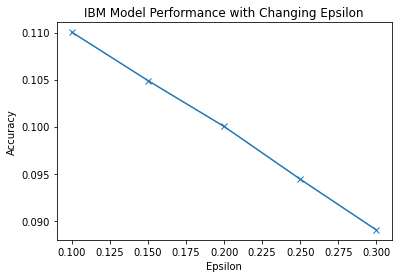

In [19]:
import matplotlib.pyplot as plt

#Plot Chart 
epsilon = [0.10, 0.15,0.20,0.25,0.30]
scores = [0.11002971436418181,0.10489276139410188,0.1000173537848289,0.09441981046140197,0.08902807292249189]

plt.plot(epsilon, scores, marker='x')
plt.title("IBM Model Performance with Changing Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")          
plt.savefig("ibm_acc_ep.png")

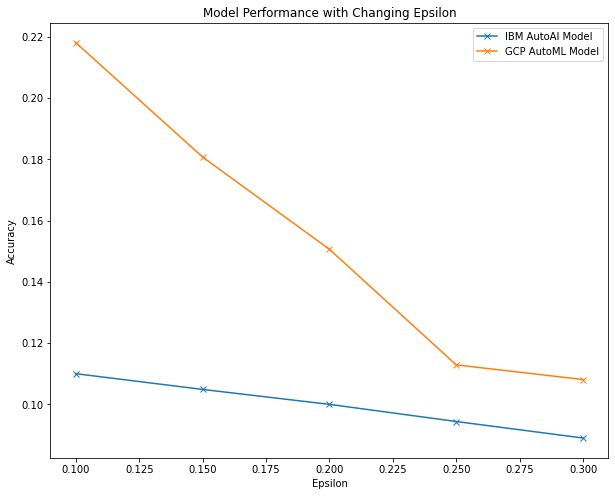

In [2]:
import matplotlib.pyplot as plt

#Plot  Both Charts 
epsilon = [0.10, 0.15,0.20,0.25,0.30]
ibm_scores = [0.11002971436418181,0.10489276139410188,0.1000173537848289,0.09441981046140197,0.08902807292249189]
gcp_scores = [0.21806, 0.18073, 0.15062, 0.11290, 0.10812]

fig = plt.figure(figsize=(10,8))
plt.plot(epsilon, ibm_scores, marker='x', label="IBM AutoAI Model")
plt.plot(epsilon, gcp_scores, marker='x', label="GCP AutoML Model")
plt.title("Model Performance with Changing Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")  
plt.legend()
plt.savefig("acc_ep.png")

## Get Log Probability Labels

In [54]:
proba_predict = pipeline.predict_proba(test_data.iloc[:, 1:].values)
proba_predict.to_csv('ibm_predictions.csv', sep=',', index_col = None)